# garbage_objectIdentification_ramudroid

Model Training with TensorFlow Lite

## Setup



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.6.2


## Build a model for tarining

In [2]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

## Prepare the data


In [16]:
# import tensorflow_datasets as tfds

# builder = tfds.ImageFolder('litter_sample_dataset')
# print(builder.info)  # num examples, labels... are automatically calculated
# ds = builder.as_dataset(split='train', shuffle_files=True)
# tfds.show_examples(ds, builder.info)  

In [8]:
# import pathlib

# dataset_url = "litter_sample_dataset.tar.xz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                    fname='litter_dataset',
#                                    untar=True)
# data_dir = pathlib.Path(data_dir)

# list_ds = tf.data.Dataset.list_files(str(data_dir)+ str('*/*.jpg'))
# (train_images, train_labels), (test_images, test_labels) = list_ds.load_data()

In [17]:
data_dir = "litter_sample_dataset"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
paper_count = list(data_dir.glob('paper/*'))
print(paper_count)


3652
[PosixPath('litter_sample_dataset/paper/paper183.jpg'), PosixPath('litter_sample_dataset/paper/paper239.jpg'), PosixPath('litter_sample_dataset/paper/paper583.jpg'), PosixPath('litter_sample_dataset/paper/paper486.jpg'), PosixPath('litter_sample_dataset/paper/paper152.jpg'), PosixPath('litter_sample_dataset/paper/paper487.jpg'), PosixPath('litter_sample_dataset/paper/paper60.jpg'), PosixPath('litter_sample_dataset/paper/paper45.jpg'), PosixPath('litter_sample_dataset/paper/paper235.jpg'), PosixPath('litter_sample_dataset/paper/paper266.jpg'), PosixPath('litter_sample_dataset/paper/paper521.jpg'), PosixPath('litter_sample_dataset/paper/paper581.jpg'), PosixPath('litter_sample_dataset/paper/paper572.jpg'), PosixPath('litter_sample_dataset/paper/paper566.jpg'), PosixPath('litter_sample_dataset/paper/paper278.jpg'), PosixPath('litter_sample_dataset/paper/paper558.jpg'), PosixPath('litter_sample_dataset/paper/paper205.jpg'), PosixPath('litter_sample_dataset/paper/paper338.jpg'), PosixP

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  image_size=(256, 256),
  seed=1,
  batch_size=32)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(256, 256),
  batch_size=32)

for x, y in train_ds.take(5):
  print('Image --> ', x.shape, 'Label --> ',  y.shape)

Found 3667 files belonging to 11 classes.
Using 2934 files for training.
Found 3667 files belonging to 11 classes.
Using 733 files for validation.
Image -->  (32, 256, 256, 3) Label -->  (32,)
Image -->  (32, 256, 256, 3) Label -->  (32,)
Image -->  (32, 256, 256, 3) Label -->  (32,)
Image -->  (32, 256, 256, 3) Label -->  (32,)
Image -->  (32, 256, 256, 3) Label -->  (32,)


In [26]:
class_names = train_ds.class_names
print(class_names)

['augmentation', 'cardboard', 'glass', 'leaf', 'metal', 'paper', 'plastic', 'polythenebag', 'recyclable', 'test', 'wrapper']


## Visualize the data

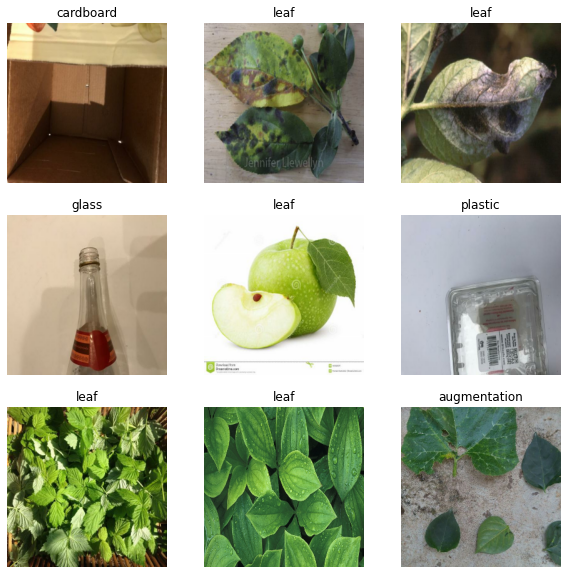

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Preprocess the dataset



In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.013725491 1.0


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# # Pixel values in this dataset are between 0 and 255, and must be normalized to a value between 0 and 1 
# # for processing by the model. Divide the values by 255 to make this adjustment.

# train_images = (train_images / 255.0).astype(np.float32)
# test_images = (test_images / 255.0).astype(np.float32)

Convert the data labels to categorical values by performing one-hot encoding.

In [38]:
# train_labels = tf.keras.utils.to_categorical(train_labels)
# test_labels = tf.keras.utils.to_categorical(test_labels)

Note: Make sure you preprocess your *training* and *testing* datasets in the same way, so that your testing accurately evaluate your model's performance.

## Train the model

The following code runs model training for 100 epochs, processing batches of 100 images at a time, and displaying the loss value after every 10 epochs. 


In [44]:
num_classes = 11

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [45]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [46]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 775s 8s/step - loss: 1.3881 - accuracy: 0.4990 - val_loss: 1.0955 - val_accuracy: 0.6003
Epoch 2/3
92/92 [==============================] - 429s 5s/step - loss: 0.9967 - accuracy: 0.6472 - val_loss: 0.9719 - val_accuracy: 0.6698
Epoch 3/3
92/92 [==============================] - 129s 1s/step - loss: 0.8428 - accuracy: 0.6895 - val_loss: 0.8778 - val_accuracy: 0.6999


In [50]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

NameError: name 'train_images' is not defined

In [40]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

Note: You should complete initial training of your model before converting it to TensorFlow Lite format, so that the model has an initial set of weights, and is able to perform reasonable inferences *before* you start collecting data and conducting training runs on the device.

## Convert model to TensorFlow Lite format

After you have extended your TensorFlow model to enable additional functions for on-device training and completed initial training of the model, you can convert it to TensorFlow Lite format. The following code converts and saves your model to that format, including the set of signatures that you use with the TensorFlow Lite model on a device: `train, infer, save, restore`.

In [ ]:
# Save the trained weights to a checkpoint.
model.save('model.ckpt')

In [49]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

AttributeError: 'Sequential' object has no attribute 'train'

### Setup the TensorFlow Lite signatures

The TensorFlow Lite model you saved in the previous step contains several function signatures. You can access them through the `tf.lite.Interpreter` class and invoke each `restore`, `train`, `save`, and `infer` signature separately.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

Compare the output of the original model, and the converted lite model:

In [ ]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

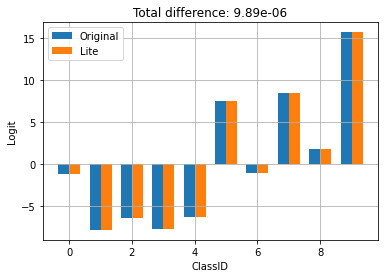

In [ ]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

Above, you can see that the behavior of the model is not changed by the conversion to TFLite.

## Retrain the model on a device

After converting your model to TensorFlow Lite and deploying it with your app, you can retrain the model on a device using new data and the `train` signature method of your model. Each training run generates a new set of weights that you can save for re-use and further improvement of the model, as shown in the next section.

Note: Since training tasks are resource intensive, you should consider performing them when users are not actively interacting with the device, and as a background process. Consider using the [WorkManager](https://developer.android.com/topic/libraries/architecture/workmanager) API to schedule model retraining as an asynchronous task.

On Android, you can perform on-device training with TensorFlow Lite using either Java or C++ APIs. In Java, use the `Interpreter` class to load a model and drive model training tasks. The following example shows how to run the training procedure using the `runSignature` method:


```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int BATCH_SIZE = 100;
    int IMG_HEIGHT = 28;
    int IMG_WIDTH = 28;
    int NUM_TRAININGS = 60000;
    int NUM_BATCHES = NUM_TRAININGS / BATCH_SIZE;

    List<FloatBuffer> trainImageBatches = new ArrayList<>(NUM_BATCHES);
    List<FloatBuffer> trainLabelBatches = new ArrayList<>(NUM_BATCHES);

    // Prepare training batches.
    for (int i = 0; i < NUM_BATCHES; ++i) {
        FloatBuffer trainImages = FloatBuffer.allocateDirect(BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH).order(ByteOrder.nativeOrder());
        FloatBuffer trainLabels = FloatBuffer.allocateDirect(BATCH_SIZE * 10).order(ByteOrder.nativeOrder());

        // Fill the data values...
        trainImageBatches.add(trainImages.rewind());
        trainImageLabels.add(trainLabels.rewind());
    }

    // Run training for a few steps.
    float[] losses = new float[NUM_EPOCHS];
    for (int epoch = 0; epoch < NUM_EPOCHS; ++epoch) {
        for (int batchIdx = 0; batchIdx < NUM_BATCHES; ++batchIdx) {
            Map<String, Object> inputs = new HashMap<>();
            inputs.put("x", trainImageBatches.get(batchIdx));
            inputs.put("y", trainLabelBatches.get(batchIdx));

            Map<String, Object> outputs = new HashMap<>();
            FloatBuffer loss = FloatBuffer.allocate(1);
            outputs.put("loss", loss);

            interpreter.runSignature(inputs, outputs, "train");

            // Record the last loss.
            if (batchIdx == NUM_BATCHES - 1) losses[epoch] = loss.get(0);
        }

        // Print the loss output for every 10 epochs.
        if ((epoch + 1) % 10 == 0) {
            System.out.println(
              "Finished " + (epoch + 1) + " epochs, current loss: " + loss.get(0));
        }
    }

    // ...
}
```


You can see a complete code example of model retraining inside an Android app in the [model personalization demo app](https://github.com/tensorflow/examples/blob/master/lite/examples/model_personalization/android/transfer_api/src/main/java/org/tensorflow/lite/examples/transfer/api/LiteMultipleSignatureModel.java).

Run training for a few epochs to improve or personalize the model. In practice, you would run this additional training using data collected on the device. For simplicity, this example uses the same training data as the previous training step.

In [ ]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])


for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

Finished 10 epochs
  loss: 0.223
Finished 20 epochs
  loss: 0.216
Finished 30 epochs
  loss: 0.210
Finished 40 epochs
  loss: 0.204
Finished 50 epochs
  loss: 0.198


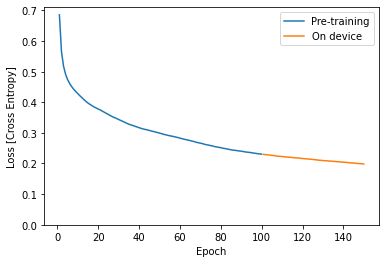

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

Above you can see that the on-device training picks up exactly where the pretraining stopped.

## Save the trained weights

When you complete a training run on a device, the model updates the set of weights it is using in memory. Using the `save` signature method you created in your TensorFlow Lite model, you can save these weights to a checkpoint file for later reuse and improve your model.

In [ ]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'/tmp/model.ckpt', dtype=object)}

In your Android application, you can store the generated weights as a checkpoint file in the internal storage space allocated for your app.

```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    interpreter.runSignature(inputs, outputs, "save");
}
```

## Restore the trained weights

Any time you create an interpreter from a TFLite model, the interpreter will initially load the original model weights.

So after you've done some training and saved a checkpoint file, you'll need to run the `restore` signature method to load the checkpoint.

A good rule is "Anytime you create an Interpreter for a model, if the checkpoint exists, load it". If you need to reset the model to the baseline behavior, just delete the checkpoint and create a fresh interpreter.


In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

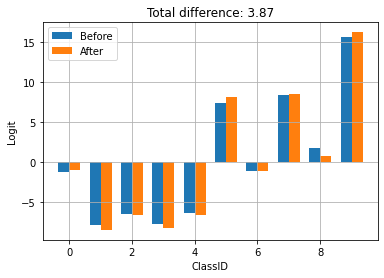

In [ ]:
logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})

The checkpoint was generated by training and saving with TFLite. Above you can see that applying the checkpoint updates the behavior of the model.

Note: Loading the saved weights from the checkpoint can take time, based on the number of variables in the model and the size of the checkpoint file.


In your Android app, you can restore the serialized, trained weights from the checkpoint file you stored earlier.

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    anotherInterpreter.runSignature(inputs, outputs, "restore");
}
```

Note: When your application restarts, you should reload your trained weights prior to running new inferences.

## Run Inference using trained weights

Once you have loaded previously saved weights from a checkpoint file, running the `infer` method uses those weights with your original model to improve predictions. After loading the saved weights, you can use the `infer` signature method as shown below.

Note: Loading the saved weights is not required to run an inference, but running in that configuration produces predictions using the originally trained model, without improvements.

In [ ]:
infer = another_interpreter.get_signature_runner("infer")
result = infer(x=test_images)
predictions = np.argmax(result["output"], axis=1)

true_labels = np.argmax(test_labels, axis=1)

In [ ]:
result['output'].shape

(10000, 10)

Plot the predicted labels.

In [47]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# def plot(images, predictions, true_labels):
#   plt.figure(figsize=(10,10))
#   for i in range(25):
#       plt.subplot(5,5,i+1)
#       plt.xticks([])
#       plt.yticks([])
#       plt.grid(False)
#       plt.imshow(images[i], cmap=plt.cm.binary)
#       color = 'b' if predictions[i] == true_labels[i] else 'r'
#       plt.xlabel(class_names[predictions[i]], color=color)
#   plt.show()

# plot(test_images, predictions, true_labels)

In [ ]:
predictions.shape

(10000,)

In your Android application, after restoring the trained weights, run the inferences based on the loaded data.

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    FloatBuffer testImages = FloatBuffer.allocateDirect(NUM_TESTS * 28 * 28).order(ByteOrder.nativeOrder());
    FloatBuffer output = FloatBuffer.allocateDirect(NUM_TESTS * 10).order(ByteOrder.nativeOrder());

    // Fill the test data.

    // Run the inference.
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("x", testImages.rewind());
    Map<String, Object> outputs = new HashMap<>();
    outputs.put("output", output);
    anotherInterpreter.runSignature(inputs, outputs, "infer");
    output.rewind();

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output.get(i * 10 + index) < output.get(i * 10 + j)) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```